In [3]:
!pip install requests
!pip install pandas
!pip install beautifulsoup4

In [1]:
import re
from collections import namedtuple
import requests
from bs4 import BeautifulSoup

UserReview = namedtuple('UserReview', ['product_name', 'review_title', 'comment', 'rating', 'date', 'username', 'profile_url', 'verified_purchase'])

class AmazonScraper:
    review_date_pattern = re.compile('(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?) \d+, \d{4}')
    product_name_pattern = re.compile('^https:\/{2}www.amazon.com\/(.+)\/product-reviews')
    def __init__(self):
        # create a browser session
        self.session = requests.Session()
        self.session.headers['User-Agent'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv: 87.0) Gecko/20100101 Firefox/87.0'
        self.session.headers['Accept'] = 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
        self.session.headers['Accept-Language'] = 'en-US,en;q=0.5'
        self.session.headers['Connection'] = 'keep-alive'
        self.session.headers['Upgrade-Insecure-Requests'] = '1'

    def scrapeReviews(self, url, page_num, filter_by='recent'):
        """
        args
            filter_by: recent or helpful
        return
            namedtuple
        """
        try:
            review_url = re.search('^.+(?=\/)', url).group()
            review_url = review_url + '?reviewerType=all_reviews&sortBy={0}&pageNumber={1}'.format(filter_by, page_num)
            print('Processing {0}...'.format(review_url))
            response = self.session.get(review_url)

            product_name = self.product_name_pattern.search(url).group(1) if self.product_name_pattern.search(url) else ''
            if not product_name:
                print('url is invalid. Please check the url.')
                return
            else:
                product_name = product_name.replace('-', ' ')

            soup = BeautifulSoup(response.content, 'html.parser')
            review_list = soup.find('div', {'id': 'cm_cr-review_list' })    

            reviews = []
            product_reviews = review_list.find_all('div', {'data-hook': 'review'}) # return reviews
            for product_review in product_reviews:
                review_title = product_review.find('a', {'data-hook': 'review-title'}).text.strip()
                verified_purchase = True if product_review.find('span', {'data-hook': 'avp-badge'}) else False
                review_body = product_review.find('span', {'data-hook': 'review-body'}).text.strip()
                rating = product_review.find('i', {'data-hook': 'review-star-rating'}).text
                review_date = self.review_date_pattern.search(product_review.find('span', {'data-hook': 'review-date'}).text).group(0)
                username = product_review.a.span.text
                user_profile = 'https://amazon.com/{0}'.format(product_review.a['href'])
                reviews.append(UserReview(product_name, review_title, review_body, rating, review_date, username, user_profile, verified_purchase))
            return reviews
        except Exception as e:
            print(e)
            return None

In [3]:
import time
import pandas as pd
from amazon_review_scraper import AmazonScraper

"""
pip install requests
pip install pandas
pip install beautifulsoup4
"""

reviews = []
amz_scraper = AmazonScraper()

product_url = 'https://www.amazon.com/Big-Book-Dashboards-Visualizing-Real-World/product-reviews/1119282713/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2'

for page_num in range(2, 6):
	reviews.extend(amz_scraper.scrapeReviews(url=product_url, page_num=page_num))
	time.sleep(1)

df = pd.DataFrame(reviews)
df.to_excel('amazon product review ({0}).xlsx'.format(reviews[0].product_name), index=False)

ImportError: cannot import name 'AmazonScraper' from 'amazon_review_scraper' (unknown location)

In [8]:
pip install amazon_review_scraper

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for amazon_review_scraper: filename=amazon_review_scraper-0.1.2-py3-none-any.whl size=2954 sha256=a54a0c6c66fc83d895ec8c6cc8a61e05223e03f83e935f02274a81fa43c48849
  Stored in directory: c:\users\mazhar\appdata\local\pip\cache\wheels\ef\08\a4\0b98f019c3b86a8c1728ed1f3377a53ac8c55ff67679180659
Successfully built amazon_review_scraper
Note: you may need to restart the kernel to use updated packages.


In [8]:

import scrapy
from urllib.parse import urljoin

class AmazonReviewsSpider(scrapy.Spider):
    name = "amazon_reviews"

    def start_requests(self):
        asin_list = ['B08R61G69Q']
        for asin in asin_list:
            amazon_reviews_url = f'https://www.amazon.com/product-reviews/{asin}/'
            yield scrapy.Request(url=amazon_reviews_url, callback=self.parse_reviews, meta={'asin': asin})

    def parse_reviews(self, response):
        asin = response.meta['asin']
        
        ## Parse Product Reviews
        review_elements = response.css("#cm_cr-review_list div.review")
        for review_element in review_elements:
            yield {
                    "asin": asin,
                    "text": "".join(review_element.css("span[data-hook=review-body] ::text").getall()).strip(),
                    "title": review_element.css("*[data-hook=review-title]>span::text").get(),
                    "location_and_date": review_element.css("span[data-hook=review-date] ::text").get(),
                    "verified": bool(review_element.css("span[data-hook=avp-badge] ::text").get()),
                    "rating": review_element.css("*[data-hook*=review-star-rating] ::text").re(r"(\d+\.*\d*) out")[0],
                    }


In [9]:
scrapy crawl amazon_reviews 

SyntaxError: invalid syntax (2346674028.py, line 1)

In [19]:
import requests
from bs4 import BeautifulSoup

def scrape_amazon_reviews(product_url):
  """Scrapes Amazon reviews from the given product URL.

  Args:
    product_url: The URL of the Amazon product to scrape reviews from.

  Returns:
    A list of dictionaries, where each dictionary represents a single review.
  """

  # Make a request to the Amazon product URL.
  response = requests.get(product_url)

  # Parse the HTML response.
  soup = BeautifulSoup(response.content, 'html.parser')

  # Extract the review data.
  reviews = []
  for review in soup.find_all('div', class_='a-section review aok-relative'):
    reviewer_name = review.find('span', class_='a-profile-name').text
    review_rating = float(review.find('i', class_='a-icon-alt').text)
    review_text = review.find('span', class_='a-size-base review-text review-text-content').text

    # Create a dictionary to represent the review.
    review_data = {
      'reviewer_name': reviewer_name,
      'review_rating': review_rating,
      'review_text': review_text
    }

    # Add the review data to the list of reviews.
    reviews.append(review_data)

  return reviews


# Get the Amazon product URL.
product_url = 'https://www.amazon.com/Google-Pixel-4a-Smartphone-Ultrawide/product-reviews/B08R61G69Q/'

# Scrape the Amazon reviews.
reviews = scrape_amazon_reviews(product_url)

# Print the reviews.
for review in reviews:
  print(review)


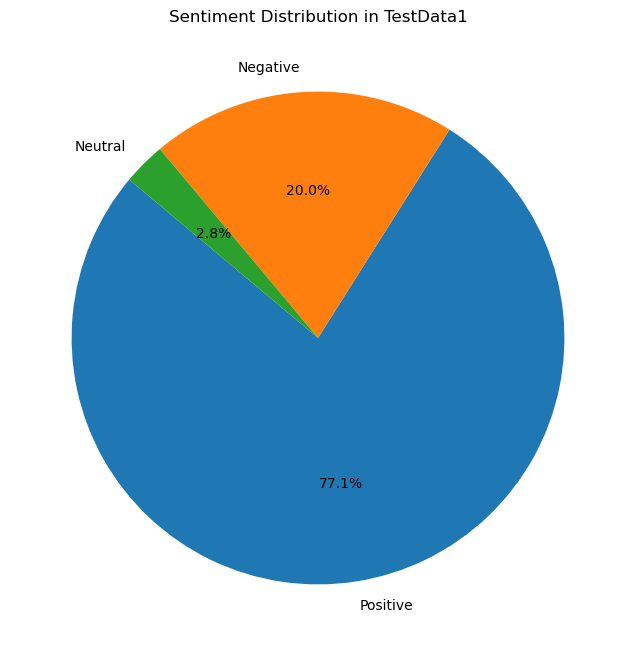

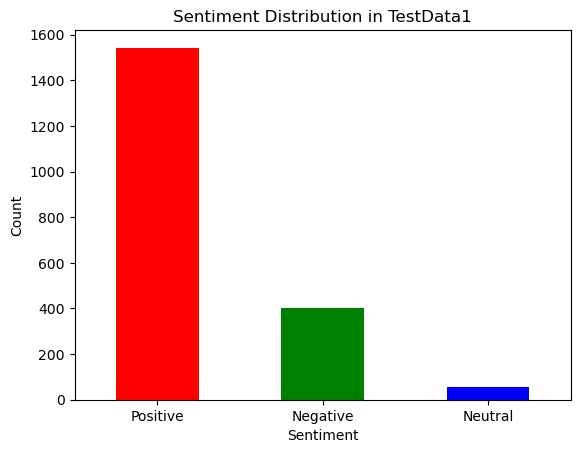

MemoryError: Unable to allocate 1.36 GiB for an array with shape (19979, 18233) and data type int32

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from textblob import TextBlob
#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Load TestData1.csv
#data1_path = "/content/drive/My Drive/Colab Notebooks/NLP Project/Trial&Error/test2.csv"
data1_path = 'test2.csv'
df1 = pd.read_csv(data1_path, header=None, names=["Review"]).dropna()

# Load TestData2.csv
#data2_path = "/content/drive/My Drive/Colab Notebooks/NLP Project/Trial&Error/train3.csv"
data2_path = 'train3.csv'
df2 = pd.read_csv(data2_path, header=None, names=["Sentiment Score", "Review Title", "Review"]).dropna()

# Sentiment analysis using TextBlob
def get_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to calculate sentiment score for each review in TestData1
df1["Sentiment Score"] = df1["Review"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Assign sentiment class based on sentiment score in TestData1
df1["Sentiment"] = df1["Sentiment Score"].apply(get_sentiment)

# Pie chart for sentiment distribution in TestData1
sentiment_counts_df1 = df1["Sentiment"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts_df1, labels=sentiment_counts_df1.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in TestData1')
plt.show()

# Bar chart for sentiment distribution in TestData1
sentiment_counts_df1.plot(kind='bar', rot=0, color=['red', 'green', 'blue'])
plt.title('Sentiment Distribution in TestData1')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Split the data for training and testing in TestData2
X_train, X_test, y_train, y_test = train_test_split(df2['Review'], df2['Review Title'], test_size=0.2, random_state=42)

# Create a Bag-of-Words model
#vectorizer = CountVectorizer()
#X_train_vectorized = vectorizer.fit_transform(X_train)
# Create a Bag-of-Words model with a limit on the number of features
vectorizer = CountVectorizer(max_features=5000)  # Adjust the number as needed
X_train_vectorized = vectorizer.fit_transform(X_train)

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# Predict the review titles on the entire dataset in TestData2
df2["Predicted Review Title"] = classifier.predict(vectorizer.transform(df2["Review"]))

# Save the results to a new CSV file
output_path = "/content/drive/My Drive/Colab Notebooks/NLP Project/Trial&Error/output.csv"
output_path = "output.csv"
df2[['Sentiment Score', 'Predicted Review Title', 'Review']].to_csv(output_path, index=False)

# Create WordClouds for each sentiment class based on the predicted review titles in TestData2
for sentiment_class in df2["Sentiment Score"].apply(get_sentiment).unique():
    text = ' '.join(df2[df2["Sentiment Score"].apply(get_sentiment) == sentiment_class]["Predicted Review Title"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for {sentiment_class} Predicted Review Titles in TestData2')
    plt.axis('off')
    plt.show()
